In [83]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""Data preprocessing for HCMC survey dataset"""

__author__ = "Anna Buch, Heidelberg University"
__email__ = "a.buch@stud.uni-heidelberg.de"


# Feature selection done by Conditional Inference Trees and its Random Forest adaption

CIT uses p-value as one-a-split criterion instead of using homogeneity. The algorithm will pick the feature with the least p-value and will start splitting from it. Then it will keep going until it no longer finds statistically significant p-value or some other criteria have met such as minimum node size or max split. 

In [84]:
import sys
import numpy as np
import pandas as pd
import pickle

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt

sys.path.insert(0, "../../../")
import utils.utils_feature_selection as fs
import utils.settings as s
import utils.utils_evaluation as e

s.init()
seed = s.seed


pd.set_option('display.max_columns', None)
plt.figure(figsize=(20, 10))

import warnings
warnings.filterwarnings('ignore')


# ruff check ./model_preprocessing/Feature_selection/utils_feature_selection.py --fix

<Figure size 2000x1000 with 0 Axes>

## Load R packages to process Conditional Random Forest in python
*Note 1: all needed R packages have to be previously loaded in R*

*Note 2: Make sure that caret package version >= 6.0-81, otherwise caret.train() throws an error*

In [85]:
import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr, data
import rpy2.robjects.packages as rpackages


# get basic R packages
utils = importr('utils')
base = importr('base')
dplyr = importr('dplyr')
stats = importr("stats")

# pandas.DataFrames to R dataframes 
from rpy2.robjects import pandas2ri, Formula
pandas2ri.activate()

# print r df in html
import rpy2.ipython.html
rpy2.ipython.html.init_printing()


# get libraries for CRF processing, ctree_controls etc
partykit = importr('partykit')
party = importr('party')
caret = importr('caret') # package version >=
#stablelearner = importr('stablelearner')
ggplot2 = importr('ggplot2')


### input data

In [86]:
df_candidates = pd.read_excel("../../../input_survey_data/input_data_contentloss.xlsx")
#df_candidates = pd.read_excel("../../../input_survey_data/input_data_businessreduction.xlsx")

targets = ["Target_contentloss_euro", "Target_businessreduction"]
target = targets[0]

print(df_candidates.shape)
df_candidates.tail(2)


(397, 42)


,Target_contentloss_euro,inundation_duration_h,water_depth_cm,contaminations.0,flowvelocity,emergency_measures.1,emergency_measures.2,emergency_measures.3,emergency_measures.4,emergency_measures.6,emergency_measures.7,emergency_measures.8,emergency_measures.9,overall_problem_house,protect_valuables_impl,water_barriers_impl,pumping_equipment_impl,elevation_building_impl,resistant_material_building_impl,electricity_higher_impl,flood_protections_impl,flood_experience,elevation_building_height_cm,elevation_rel2surrounding_cat,bage,b_area,hh_monthly_income_cat,shp_owner,shp_sector,shp_employees,shp_avgmonthly_sale_cat,shp_finance_investments,shp_risk_tolerance,shp_monetary_resources4prevention,resilience_city_protection,resilience_left_alone,resilience_neighbor_management,perception_who_responsible4protection.Rank1,contaminations_light,contaminations_heavy,shp_content_value_euro,shp_registered_capital_euro
395,0.0,4.0,70.0,0,1,1,0,1,0,1,0,0,0,1,1,5,1,1,5,5,5,5,70.0,1,NaN,130.0,NaN,1,17,2,3,1,3.0,3.0,1.0,5,1.0,2.0,1,0,NaN,11047.7
396,0.0,3.0,100.0,0,1,1,0,1,0,0,0,0,0,0,1,5,5,5,5,5,5,4,NaN,0,5.0,33.0,1.0,1,11,2,3,1,3.0,4.0,NaN,5,NaN,3.0,1,0,NaN,736.5


In [87]:

## TODO make entire wokflow as loop over both target variables
# ## iterate over both targets and store results 
# for target in ["Target_contentloss_euro", "Target_businessreduction"]:

#     print( f"Apply Elastic Net on {target}:\n")
#     y = df_candidates[target]

In [88]:
## delete features with more than 10% missing values

# drop warning time due to 77% nan
df_candidates = df_candidates.drop("emergency_measures.9", axis=1)
df_candidates = df_candidates.drop("contaminations_light", axis=1)
df_candidates = df_candidates.drop("elevation_building_height_cm", axis=1)
df_candidates = df_candidates.drop("shp_content_value_euro", axis=1)
df_candidates = df_candidates.drop("shp_registered_capital_euro", axis=1)


print("Percentage of missing valeus per feature\n", df_candidates.isna().mean().sort_values(ascending=False)[:15] ) 


Percentage of missing valeus per feature
 shp_risk_tolerance                             0.070529
perception_who_responsible4protection.Rank1    0.070529
bage                                           0.068010
hh_monthly_income_cat                          0.060453
shp_monetary_resources4prevention              0.045340
Target_contentloss_euro                        0.037783
resilience_city_protection                     0.037783
resilience_neighbor_management                 0.027708
inundation_duration_h                          0.022670
b_area                                         0.005038
water_depth_cm                                 0.002519
flood_experience                               0.000000
shp_avgmonthly_sale_cat                        0.000000
shp_employees                                  0.000000
shp_sector                                     0.000000
dtype: float64


In [89]:
# df_candidates.columns
# df_candidates = df_candidates[[
#     'Target_contentloss_euro', 'inundation_duration_h', 'water_depth_cm',
#     'contaminations.0', 'flowvelocity', 
#     'emergency_measures.1','emergency_measures.2', 
#     'emergency_measures.3', 'emergency_measures.4',
#     'emergency_measures.6', 'emergency_measures.7', 'emergency_measures.8',
#     #'emergency_measures.9', 
#     'overall_problem_house',
#     #'protect_valuables_impl', 'water_barriers_impl',
#     'pumping_equipment_impl', 'elevation_building_impl',
#     'resistant_material_building_impl', 'electricity_higher_impl',
#     'flood_protections_impl', 
#     #'flood_experience',
#     #'elevation_building_height_cm', 
#     'elevation_rel2surrounding_cat', 'bage',
#     'b_area', 'hh_monthly_income_cat', 'shp_owner', 'shp_sector',
#     'shp_employees', 'shp_avgmonthly_sale_cat', 
#     #'shp_finance_investments',
#     #'shp_risk_tolerance', 'shp_monetary_resources4prevention',
#     #'resilience_city_protection', 'resilience_left_alone',
#     #'resilience_neighbor_management',
#     #'perception_who_responsible4protection.Rank1', 'contaminations_light',
#     #'contaminations_heavy', '
#     # 'shp_content_value_euro',
#     #'shp_registered_capital_euro'
# ]]

df_candidates = df_candidates.drop([
       # - "contaminations_light", "contaminations_heavy", "emergency_measures.9",
       # "shp_finance_investments",  "shp_monetary_resources4prevention",
       # - "emergency_measures.6", # BETTER DROP test rmv da nur binary
        #"elevation_rel2surrounding_cat",  # TEST
        #"shp_profits_last5years", # TEST
        #"shp_monetary_resources4prevention", # TEST 
         'shp_finance_investments',
        'shp_risk_tolerance', 'shp_monetary_resources4prevention',
        'resilience_city_protection', 'resilience_left_alone',
        'resilience_neighbor_management', 
        # already in d_cleaning RM 'resilience_more_future_affected','resilience_govern_careing', 'resilience_govern_careing_increases',
        'perception_who_responsible4protection.Rank1',
        ], axis=1)

### select only damage cases

In [90]:
print(f"Removing {df_candidates.loc[df_candidates[target]==0.00,:].shape[0]} zero loss records")
df_candidates = df_candidates.loc[df_candidates[target]!=0.00,:]

print(f"Keeping {df_candidates.shape} damage cases for model training and evaluation")

Removing 226 zero loss records
Keeping (171, 30) damage cases for model training and evaluation


In [91]:
# df_candidates.plot.scatter("shp_content_value_euro", target)
# plt.xlim(0,50000)
# plt.ylim(-100, 5000)

## Split Data

In [92]:
## Handle nan values in X

## drop records with nan
df_candidates = df_candidates.dropna()


In [93]:
## remove records where target information is missing
df_candidates = df_candidates[ ~df_candidates[f"{target}"].isna()]
print(df_candidates.shape)

X = df_candidates.drop(target, axis=1)
y = df_candidates[target]


# # TEST: replace nan with median of each variable
# for c in X.columns:
#    X[c].fillna(X[c].median(), inplace=True)

(132, 30)


In [94]:
## test train split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.10, 
    random_state=seed, shuffle=True
)

# normlaize via MinMaxScaler, transform X_train ,then use the fitted scaler for X_test
X_train, X_test = fs.normalize_X(X_train, X_test)

print("Training size", X_train.shape)
print("Test size", X_test.shape)

train = pd.concat([y_train.reset_index(), X_train], axis=1).drop("index", axis=1)
test = pd.concat([y_test.reset_index(), X_test], axis=1).drop("index", axis=1)

Training size (118, 29)
Test size (14, 29)


## Model fit

In [95]:
# ###############  CV with gridSearch TODO   ###################
# # ## specify model
# # cit_model = partykit.ctree(Formula('Target_contentloss_euro ~ .'),  
# #                                 data=train
# #                           )
# # ## hyperparameter tunning 
# # param_dist = [{'mincriterion': 0.95}]
# # cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# # cit_model_cv = GridSearchCV(estimator = cit_model, 
# #                          param_grid = param_dist
# #                          )#, scoring= 'r2', cv = folds, verbose = 1,return_train_score=True)      

# # # # fit the model
# # cit_model_cv.fit(X_train, y_train)
  

# #################### without Hyperparameter tunning  #####################
# base.set_seed(seed)

# ## CV method
# fitControl = caret.trainControl(
#     method = "repeatedcv",  # "oob" - then no repeats are needed
#     number = 10,   ## = K-folds
#     repeats = 3,  # number of tried values for mtry
#     savePredictions = "final"  # saves predictions from optimal tuning parameters
#     )


# # fit ctree
# ## Minciterion = confidence level (smaller values => larger trees; e.g mincriterion=0.8, p-value must be smaller than 0.2 in order for a node to split)
# cit_model = partykit.ctree(Formula(f'{target} ~ .'),  
#                                 data=train,
#                                 metric='MAE',#'RMSE',  # RMSE unit of target or use MAE due that more robust than RMSE further metrics options Rsquared, RMSE, MAE 
#                                 # RMSE penalizes large gaps more harshly than MAE
#                                 maximize=False,
#                                 control = partykit.ctree_control(mincriterion = 0.2),
#                                 trcontrol=fitControl
#                            )


# ## store trained model for evaluation
# filename = f'./models_trained/cit_{target}'
# pickle.dump(cit_model, open(filename, 'wb'))
# print(train.shape)
# #print(cit_model)

In [96]:
# ## Predict
# print(target)
# y_pred = stats.predict(cit_model, newdata=X_test)#, OOB=True, type="response") #  type = "prob" # conditional class probabilities extractPrediction(
# y_pred  = base.round(y_pred)

# ## get back to python dtypes
# y_pred = np.array(y_pred)
# y_test = np.array(y_test)

# ## print evaluation report + check for overfitting 
# y_pred_train = np.round(stats.predict(cit_model, newdata=X_train), 1)#.reshape(-1)
# print("\nTraining set")
# e.evaluation_report(y_train, y_pred_train, X_train.shape[1])

# print("\nTesting set")
# e.evaluation_report(y_test, y_pred, X_train.shape[1])  # 1590, 1306.9

In [97]:
##  CV with gridSearch from R 
## Due that cforest is a R package it only accepts other R functions for tunning and cross validation  
## CIT handles by default missing values in response, while CRF doesnt accept missing vlaues in response

# ## Define the hyperparamters
## NOTE: cant define hyperparameter ranges for cforest, caret.train(method="cforest") is doing this by itself
## train() Doc: https://search.r-project.org/CRAN/refmans/caret/html/train.html


base.set_seed(seed)
## CV method
fitControl = caret.trainControl(
    method = "repeatedcv",  # "oob" - then no repeats are needed
    number = 10,   ## = K-folds
    repeats = 5,  # number of tried values for mtry
    #savePredictions = "final"  # saves predictions from optimal tuning parameters
    )

# robjects.r('''
#         r_grid <- function(verbose=FALSE) {
#             expand.grid(ntree=10)
#         }
#     ''')
# f = robjects.globalenv['r_grid']
# createCfGrid = base.expand_grid(controls = party.cforest_control(mtry=3, ntree=200)) #qnorm() =90th percentile
# mincriterion=stats.qnorm(0.9) # = default
# " train() will generate the grid for you. If you want to specify ntree you just pass a controls object in as another argument to train but leave out mtry:""
# https://stackoverflow.com/questions/20337137/run-cforest-with-controls-cforest-unbiased-using-caret-package?rq=4


## CIT handles by default missing values in response, while CRF doesnt accept missing vlaues in response
base.set_seed(seed)
crf_cv = caret.train(
        Formula(f'{target} ~ .'), 
        data = train,
        method = "cforest",
        metric='MAE',#'RMSE',  # RMSE unit of target or use MAE due that more robust than RMSE further metrics options Rsquared, RMSE, MAE 
        # RMSE penalizes large gaps more harshly than MAE
        maximize=True,
        #na_action =  stats.na_pass,
        controls = party.cforest_control( 
            #party.cforest_unbiased(
            # only mtry gets tuned by grid
            mtry=2,  # mtry=0 =Bagging without random input var sampling
            ntree = 100,  # didnt improved with 200 or 500 trees
           # mincriterion = 0.05,   # the value of the test statistic (for testtype == "Teststatistic"), or 1 - p-value (for other values of testtype) that must be exceeded in order to implement a split.
            replace = False,
            #fraction = 0.632,   # fraction of number of observations to draw without replacement (only relevant if replace = FALSE).
        ),  # cforest_unbiased= subsampling without replacement repalce=False a
        trControl = fitControl,
        #tuneGrid = #params_grid, # createCfGrid
        #verbose = False
    )
print(crf_cv) # 5687.575

base.warnings()

## cforest_control
# kein mcriterion,tree=100:                            5452.801  0.1379846  1577.973
#  mcriterion=0.5, tree=500:                           5462.640  0.1377202  1591.361
# mtry=0, tree=500  replace = False , mtry = 2.       9694.786  0.1819220  4411.304
## --> repalce=True deosnt necessary gives better results
## --> mincriterion=0.5  

## cforest_unbiased
# no mcritierion possible, mtry=2, tree=500:             5452.889  0.1316165  1604.568
#   "" same as above, just mtry=5 -> but used mtry=2:    5452.889  0.1316165  1604.568
#   "" same as above, just mtry=0 (Bagging):               6807.178  0.1802000  1686.821
# mtry was set to 0 -> but used mtry=42, tree=100 :                                   11517.79  0.1972586  4454.590


Conditional Inference Random Forest 

118 samples
 29 predictor

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 5 times) 
Summary of sample sizes: 106, 106, 106, 107, 106, 106, ... 
Resampling results across tuning parameters:

  mtry  RMSE       Rsquared   MAE     
   2     9320.274  0.1661548  4298.205
  15    10168.907  0.1847214  4202.588
  29    10701.540  0.1790707  4141.982

MAE was used to select the optimal model using the largest value.
The final value used for the model was mtry = 2.



<rpy2.rinterface_lib.sexp.NULLType object at 0x0000027172070D00> [RTYPES.NILSXP]

In [98]:
## Predict
y_pred = stats.predict(crf_cv, newdata=X_test)#, OOB=True, type="response") #  type = "prob" # conditional class probabilities extractPrediction(
y_pred  = base.round(y_pred)

## get back to python dtypes
y_pred = np.array(y_pred)
y_test = np.array(y_test)

## print evaluation report + check for overfitting 
y_pred_train = np.round(stats.predict(crf_cv, newdata=X_train), 1)#.reshape(-1)
print("\nTraining set")
e.evaluation_report(y_train, y_pred_train, 
                        filepath=f"./models_evaluation/conditional_random_forest/eval_train_{target.split('_')[1]}.csv")


print("\nTesting set")
e.evaluation_report(y_test, y_pred,   # 1590, 1306.9
                        filepath=f"./models_evaluation/conditional_random_forest/eval_test_{target.split('_')[1]}.csv")



Training set
Model Performance:
        Root Mean Square Error: 19855.52
        Normalized Root Mean Square Error: 14.67
        Mean Absolute Error: 4095.58
        Mean Bias Error: 38.88
        R²-Score: 0.075
    

Testing set
Model Performance:
        Root Mean Square Error: 8600.8
        Normalized Root Mean Square Error: 9.82
        Mean Absolute Error: 3933.96
        Mean Bias Error: 548.47
        R²-Score: 0.013
    


,mse,rmse,nrmse,mae,mbe,r2
0,73973764.8,8600.800242,9.820836,3933.957143,548.471429,0.012932


In [99]:
# evalution results of the three tested models during CV and tunning
fs.r_models_cv_results(crf_cv)


,,mtry,RMSE,Rsquared,MAE,...,RsquaredSD,MAESD
0,1,2.0,9320.274030983599,0.16615479859412857,4298.205269477795,...,0.20473631978739287,4931.758247328737
1,2,15.0,10168.906962216392,0.18472140915376015,4202.588008026805,...,0.23777240727594434,5025.011861569958
2,3,29.0,10701.539733194923,0.17907068075131471,4141.982260361537,...,0.2548379876137533,5125.84448570872


In [100]:
## store trained model for evaluation
filename = f'./models_trained/crf_{target}'
pickle.dump(crf_cv, open(filename, 'wb'))


In [101]:
## get best model

#print(crf_cv.names)#$param
best_hyperparameters = fs.r_best_hyperparamters(crf_cv)
best_hyperparameters = fs.r_dataframe_to_pandas(best_hyperparameters)
print(best_hyperparameters)

   mtry
1   2.0


In [102]:
## refit model with best hyperparamters
#cit_model = partykit.ctree(Formula(f'{target} ~ .'),  
crf_model = party.cforest(Formula(f'{target} ~ .'),  
                                data=train,
                                #weights=1,
                                #control= party.cforest_control(mtry=best_hyperparameters.mtry, ntree=300)
                                control= party.cforest_unbiased(mtry=best_hyperparameters.mtry, ntree=300)
                                #control = partykit.ctree_control(mincriterion = 0.8)
                          )
print(crf_model)


	 Random Forest using Conditional Inference Trees

Number of trees:  300 

Response:  Target_contentloss_euro 
Inputs:  inundation_duration_h, water_depth_cm, contaminations.0, flowvelocity, emergency_measures.1, emergency_measures.2, emergency_measures.3, emergency_measures.4, emergency_measures.6, emergency_measures.7, emergency_measures.8, overall_problem_house, protect_valuables_impl, water_barriers_impl, pumping_equipment_impl, elevation_building_impl, resistant_material_building_impl, electricity_higher_impl, flood_protections_impl, flood_experience, elevation_rel2surrounding_cat, bage, b_area, hh_monthly_income_cat, shp_owner, shp_sector, shp_employees, shp_avgmonthly_sale_cat, contaminations_heavy 
Number of observations:  118 




## Model evaluation

In [103]:
crf_model_eval = pickle.load(open(f"./models_trained/crf_{target}", 'rb'))

#crf_model_eval = pickle.load(open(f"./models_trained/crf_{target}", 'rb'))
type(crf_model_eval)


rpy2.robjects.vectors.ListVector

In [104]:
## Predict

print(target)

y_pred = stats.predict(crf_model_eval, newdata=X_test)#, OOB=True, type="response") #  type = "prob" # conditional class probabilities extractPrediction(
y_pred  = base.round(y_pred)

## get back to python dtypes
y_pred = np.array(y_pred)
y_test = np.array(y_test)

## print evaluation report + check for overfitting 
y_pred_train = np.round(stats.predict(crf_model_eval, newdata=X_train), 1)#.reshape(-1)
print("\nTraining set")
e.evaluation_report(y_train, y_pred_train)

print("\nTesting set")
e.evaluation_report(y_test, y_pred)  # 1590, 1306.9

Target_contentloss_euro



Training set
Model Performance:
        Root Mean Square Error: 19855.52
        Normalized Root Mean Square Error: 14.67
        Mean Absolute Error: 4095.58
        Mean Bias Error: 38.88
        R²-Score: 0.075
    

Testing set
Model Performance:
        Root Mean Square Error: 8600.8
        Normalized Root Mean Square Error: 9.82
        Mean Absolute Error: 3933.96
        Mean Bias Error: 548.47
        R²-Score: 0.013
    


,mse,rmse,nrmse,mae,mbe,r2
0,73973764.8,8600.800242,9.820836,3933.957143,548.471429,0.012932


## Feature importance

In [105]:
## Code snippet from Danielas CRF script and from https://cran.r-project.org/web/packages/stablelearner/vignettes/forests.html

## Calculate variance importance based on selection frequency
# varimp = party.varimp(model, measures=["freq"])
# varimp_df = pd.DataFrame({'Variable': varimp.names, 'Importance': varimp})
## Sort the variable importance in descending order
# varimp_df = varimp_df.sort_values(by='freq', ascending=False)
## Plot the variance importance
# varimp_df.plot(kind='bar', x='term', y='freq', figsize=(10, 6))

# Extract variable importance values from the model
varimp = party.varimp(crf_model, conditional = True )  # compute conditional variable importance scores
# t = caret.varImp(crf_model)#, conditional=True) # caret derives FI a bit differently than party package
# pd.DataFrame({"names":X.columns.to_list(), "importances":pd.Series(t)[0]}).sort_values("importances", ascending=False).head(5)


Exception ignored from cffi callback <function _callback at 0x00000271724C1AF0>:
Traceback (most recent call last):
  File "c:\Anaconda\envs\py396_c3\lib\site-packages\rpy2\rinterface_lib\callbacks.py", line 329, in _callback
    try:
KeyboardInterrupt: 


In [ ]:
varimp

array([-5.19997089e+05,  2.23055806e+05,  0.00000000e+00,  3.97822201e+05,
        1.23512119e+04, -6.12748497e+04, -3.82051254e+04, -3.18881921e+05,
        7.70345205e+04,  1.45679200e+05,  0.00000000e+00, -1.39186059e+02,
       -4.24174029e+05,  2.75498702e+05, -2.27007553e+03, -1.46943839e+05,
       -3.19491218e+03, -5.40854200e+04,  0.00000000e+00,  1.05465621e+05,
        2.94141327e+04, -2.34927585e+05, -4.95047254e+04,  1.77174178e+05,
        7.06148940e+03, -1.99461282e+05,  3.35327042e+05,  9.28430465e+04,
       -5.73933234e+01])

In [ ]:
y_train.shape

(118,)

In [ ]:
# # ## Feature importance 

df_importance = pd.DataFrame({
    "name" : X_train.columns.to_list(),
    "importances" : varimp,
     }) 
df_importance = df_importance.sort_values("importances", ascending=False)  # get most important features to the top
df_importance.head(5)


,name,importances
3,flowvelocity,397822.200668
26,shp_employees,335327.041844
13,water_barriers_impl,275498.701596
1,water_depth_cm,223055.805529
23,hh_monthly_income_cat,177174.178024


In [ ]:
## define threshold according to Hilpert 2020: "The rule of thumb is to take the absolute minimum value as a cutoff point."" 
fi_threshold = np.abs(np.min(varimp))
fi_threshold
print(fi_threshold)

## this is to high set to fi_threshold = fi_threshold /10
fi_threshold = fi_threshold # / 5
print(fi_threshold)

519997.0891648732
519997.0891648732


In [ ]:
fi_threshold = 20000
df_importance = df_importance.loc[df_importance.importances > 0.000, : ]      # drop features which dont reduce the loss
#df_importance = df_importance.loc[df_importance.importances > fi_threshold, : ]      # drop features which dont reduce the loss

df_importance = df_importance.sort_values("importances", ascending=True)
print("5 most important features:")
df_importance.shape

5 most important features:


(12, 2)

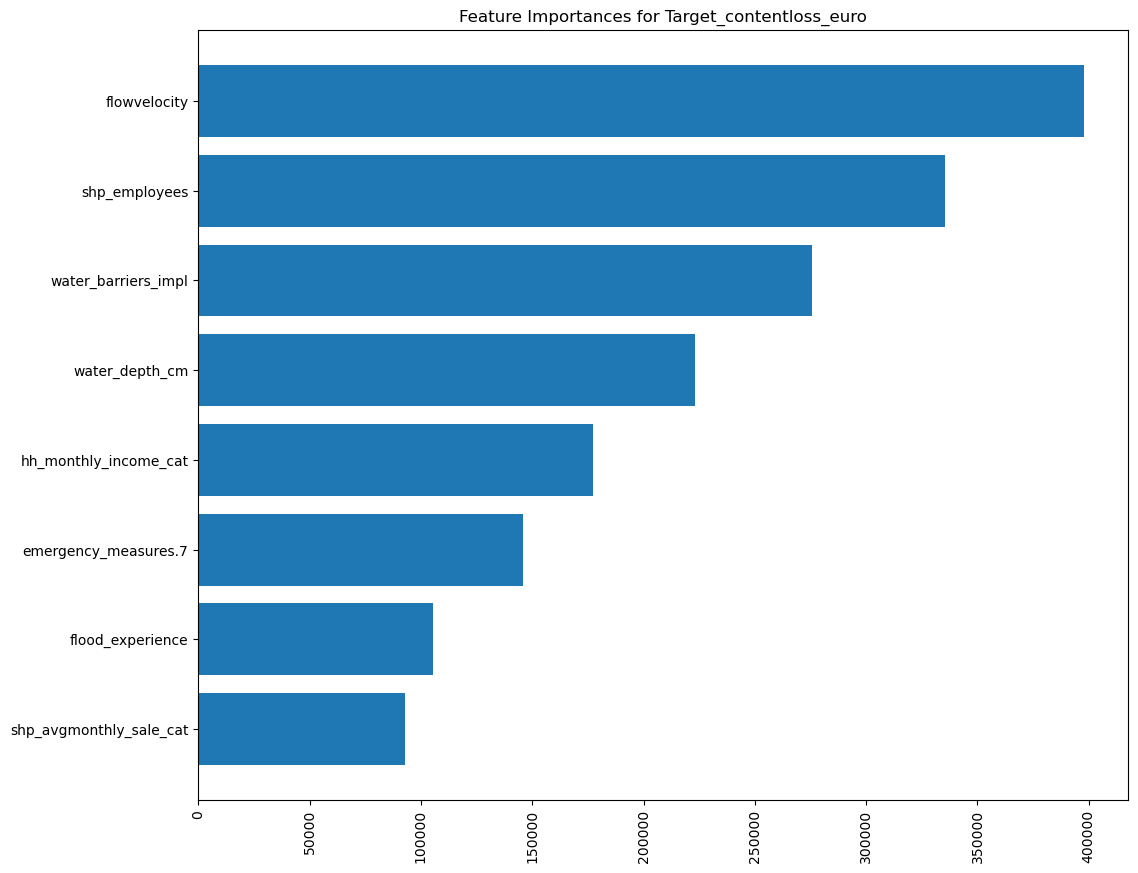

In [ ]:
# plot feature importance
fig, ax = plt.subplots(figsize=(12,10))


# keep only features which reduce the loss
df_importance = df_importance.loc[df_importance.importances > 0, : ]

plt.barh(df_importance.name[-8:], df_importance.importances[-8:])
plt.xticks(
    #ticks = range(len(selected_feat)),
    #labels = X_unscaled.iloc[:,selected_feat],
    rotation = 90
    )
plt.title(f"Feature Importances for {target}")

plt.show()

In [77]:
### Save to disk

In [78]:
##Feature selection
selected_feat = df_importance.T.columns

## write selected predictors to disk
fs.save_selected_features(X_train, pd.DataFrame(y_train), selected_feat, filename=f"../../input_survey_data/fs_crf_{target}.xlsx")


KeyError: "None of [Index([24, 4, 20, 8, 27, 19, 9, 23, 1, 13, 26, 3], dtype='int64')] are in the [columns]"

#### Statistics related to CIT and CRF

The log rather than the p-value is used because it is numerically much more stable when used for comparisons, computing the minimal value, etc. Note that the p-values can become extremely small when significant. 


statistic DEF: 

citrerion DEF: 



In [ ]:
# ## get signifcant features
# selected_feat = cit_stats.loc[:, cit_stats.loc["p_value",:]<= 0.05]


In [ ]:
## Snippet from: https://cran.r-project.org/web/packages/stablelearner/vignettes/forests.html
# cf_stablelearner = stablelearner.stabletree(cit_model,
#   sampler = stablelearner.subsampling, savetrees = True, B = 100, v = 0.632)
# #Internally, stablelearner::stabletree() does the following: For each of the 100 trees to be generated, the dataset is resampled according to the resampling method specified (in our case subsampling with a fraction of v = 0.632) and the function call of our initial tree (which we labeled ct_partykit) is updated with respect to this resampled data and reevaluated, resulting in a new tree. All the 100 trees together then build the forest.

# #2.2 Gaining insight into the forest
# #The following summary prints the variable selection frequency (freq) as well as the average number of splits in each variable (mean) over all 100 trees. As we do not want to focus on our initial tree (remember that we just grew a forest, where all trees are of equal interest), we set original = FALSE, as already mentioned in the introduction:
# t = base.summary(cf_stablelearner, original = False)

# ## Variable selection overview:
# ## Note: n python we can see the R df.index which contains the variable names, therefore it is not very usefull
# #pd.DataFrame(t).iloc[3,:][0] # frequency
# #pd.DataFrame(t).iloc[3,:][1] # mean
# #print(X.columns[:23])

In [ ]:
# ## actual p-values (without log)
# strucchange = importr("strucchange")
# strucchange.sctest(cit_model, node = 1)[1]  # p values

In [ ]:
cit_model_p.rx(3)

In [ ]:
cit_model_p.names
cit_model_p = np.array(cit_model_p.rx(3))
cit_model_p